#### The Data:
-  Recognizing gender by the data of voice and speech analysis (supervised learning), 

-    Data file: **``voice.csv``**

##### Each column is one of acoustic properties, i.e.,
- **label**: male or female
- **meanfreq**: mean frequency (in kHz)
- **sd**: standard deviation of frequency
- **median**: median frequency (in kHz)
- **Q25**: first quantile (in kHz)
- **Q75**: third quantile (in kHz)
- **IQR**: interquantile range (in kHz)
- **skew**: skewness (see note in specprop description)
- **kurt**: kurtosis (see note in specprop description)
- **sp.ent**: spectral entropy
- **sfm**: spectral flatness
- **mode**: mode frequency
- **centroid**: frequency centroid (see specprop)
- **meanfun**: average of fundamental frequency measured across acoustic signal
- **minfun**: minimum fundamental frequency measured across acoustic signal
- **maxfun**: maximum fundamental frequency measured across acoustic signal
- **meandom**: average of dominant frequency measured across acoustic signal
- **mindom**: minimum of dominant frequency measured across acoustic signal
- **maxdom**: maximum of dominant frequency measured across acoustic signal
- **dfrange**: range of dominant frequency measured across acoustic signal
- **modindx**: modulation index. Calculated as the accumulated absolute difference between adjacent measurements of fundamental frequencies divided by the frequency range

In [8]:
# import libraries
import autograd.numpy as np
import pandas as pd
from autograd import grad
import matplotlib.pyplot as plt
from matplotlib import gridspec
from autograd.util import flatten_func

## Take a look at the data

Let's use pandas to take a look at the data. By the following code, I move the classifier column **``"label"``** from the last column to the first. Convert label values from string to integer: **``male = 1``, ``female = -1``**.

This data consists of 3168 records.

In [2]:
voice_df = pd.read_csv('voice.csv')
voice_df = voice_df[['label'] + voice_df.columns[:-1].tolist()]

# change label values from male to 1, from female to -1
voice_df.loc[voice_df.label == 'male', 'label'] = 1
voice_df.loc[voice_df.label == 'female', 'label'] = -1

print(str('The number of data records is ')+str(len(voice_df.index)))
print(voice_df.columns) # columns' names
print(str('The number of male: ')+str(len(voice_df[voice_df.label == 1])))
print(str('The number of female: ')+str(len(voice_df[voice_df.label == -1])))

The number of data records is 3168
Index(['label', 'meanfreq', 'sd', 'median', 'Q25', 'Q75', 'IQR', 'skew',
       'kurt', 'sp.ent', 'sfm', 'mode', 'centroid', 'meanfun', 'minfun',
       'maxfun', 'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx'],
      dtype='object')
The number of male: 1584
The number of female: 1584


## Visualize multiple features relations.

In [3]:
voice_df.head()

,label,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,...,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
0,1,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,...,0.000000,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000
1,1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,...,0.000000,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632
2,1,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,...,0.000000,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512
3,1,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,...,0.083878,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119
4,1,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,...,0.104261,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274


In [63]:
import seaborn
voice_df.head()
feature_df = voice_df[['sd', 'Q25', 'Q75', 'skew', 'mode', 'kurt', 
                    'maxfun', 'maxdom', 'dfrange', 'label']]
seaborn.pairplot(feature_df, hue='label', size=2)

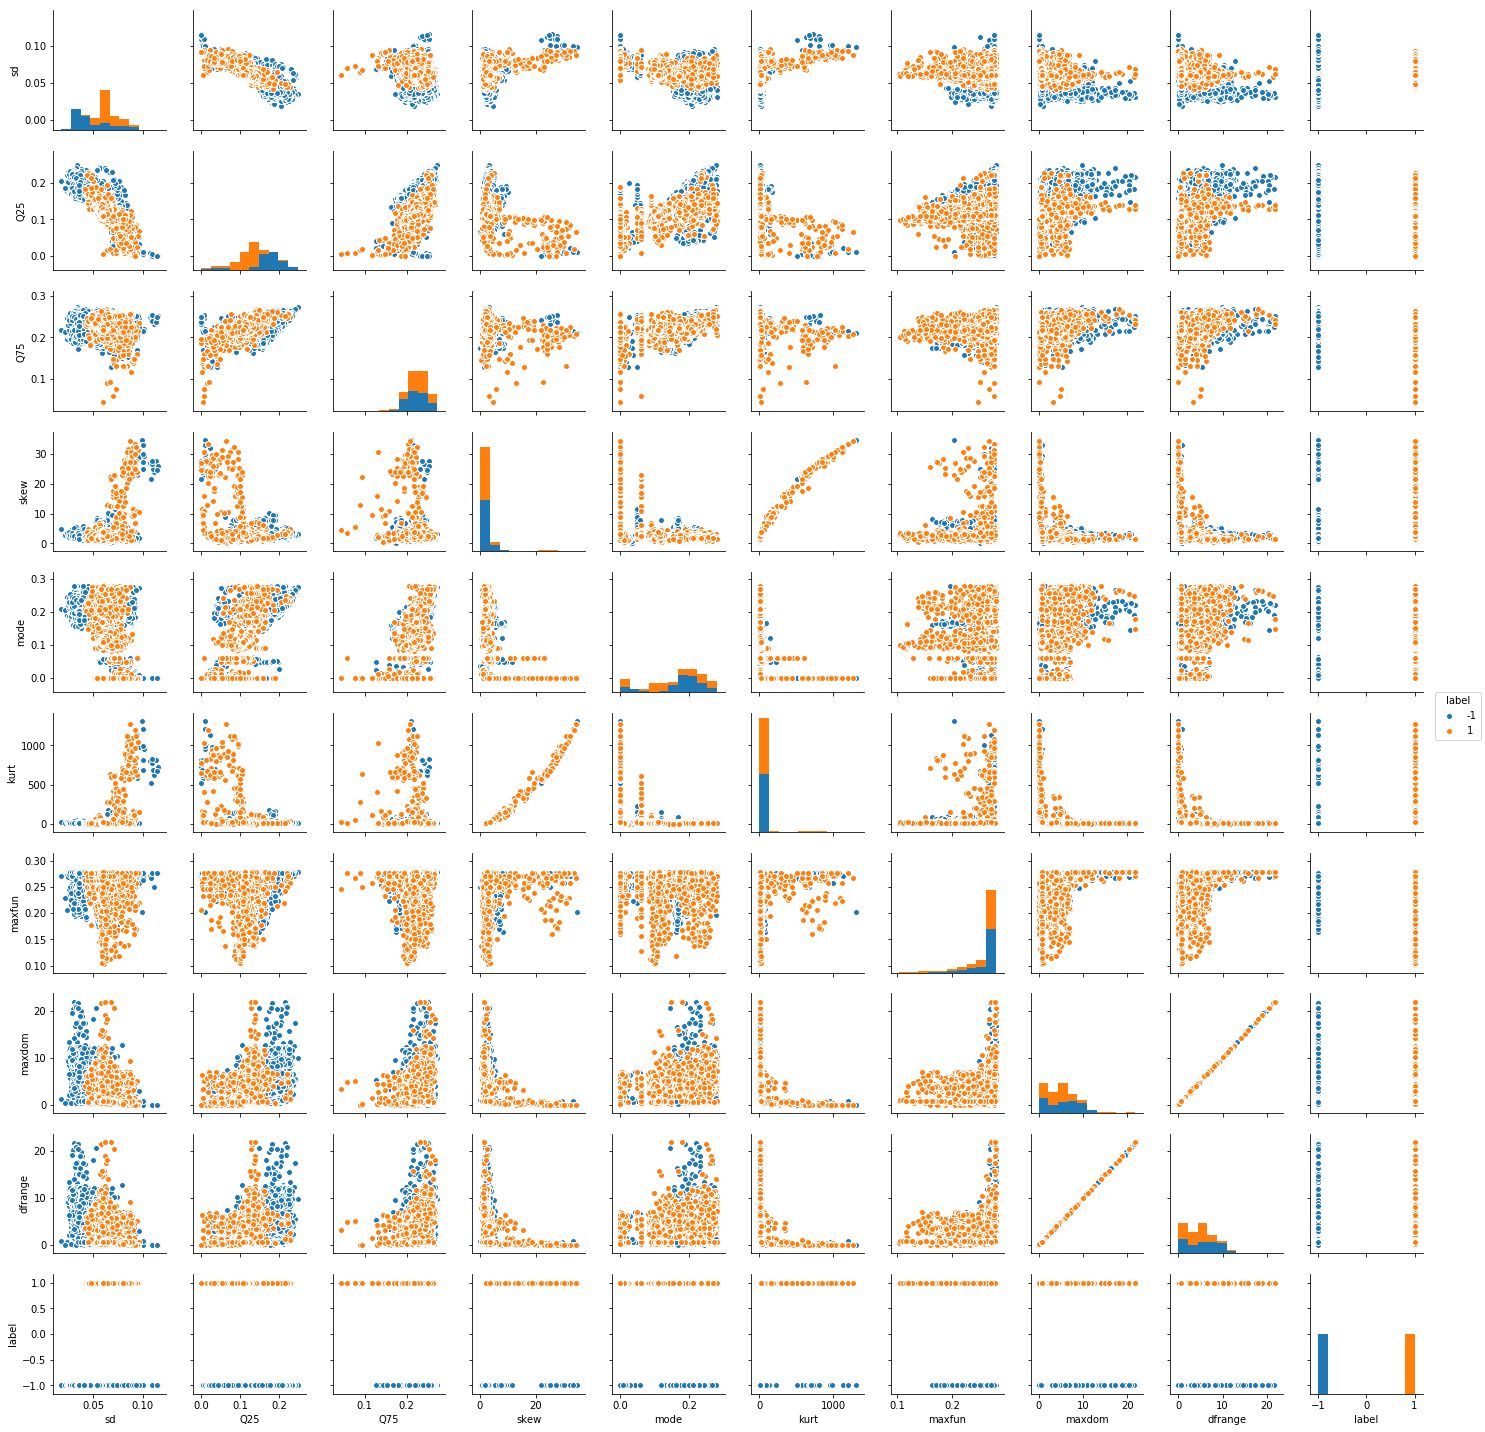

In [64]:
plt.show()

## Perform 2-class classification with unnormalized data

In [9]:
def gradient_descent(func, alpha, max_its, w):
    gradient = grad(func)
    weight_history = []
    for k in range(max_its):
        grad_eval = gradient(w)
        w = w - alpha * grad_eval
        weight_history.append(w)
    return weight_history

def softmax(w):
    cost = 0
    for p in range(0, len(y)):
        ap = w[0] + np.dot(x[p].T, w[1:])
        #ap = w[0] + sum([a*b for a, b in zip(w[1:], x[p])])
        cost += np.log(1 + np.exp(-y[p] * ap))
    return cost

def counting_cost(w):
    cost = 0
    for p in range(0, len(y)):
        ap = w[0] + np.dot(x[p].T, w[1:])
        #ap = w[0] + sum([a*b for a, b in zip(w[1:], x[p])])
        cost += (np.sign(ap)-y[p])**2
    return 0.25*cost

#### Let's take a look at the overview visualization and the relationship with each features.

In [10]:
# define the data, 
x = voice_df.iloc[:, 1:] # 20 features
y = voice_df.iloc[:, 0] # labels: male(1) or female(-1)

In [11]:
x = np.asarray(x)
y = np.asarray(y)

In [14]:
w_init = np.random.randn(21, 1)
weight_hist = gradient_descent(func=softmax, alpha=10**-6, max_its=200, w=w_init)

In [15]:
count_evals = [] # list of misclassification number 
cost_evals = [] # list of softmax cost history 
for k in range(len(weight_hist)):
    w = weight_hist[k]
    count_evals.append(counting_cost(w)) # add each misclassification number history
    cost_evals.append(softmax(w)) # add each softmax cost history

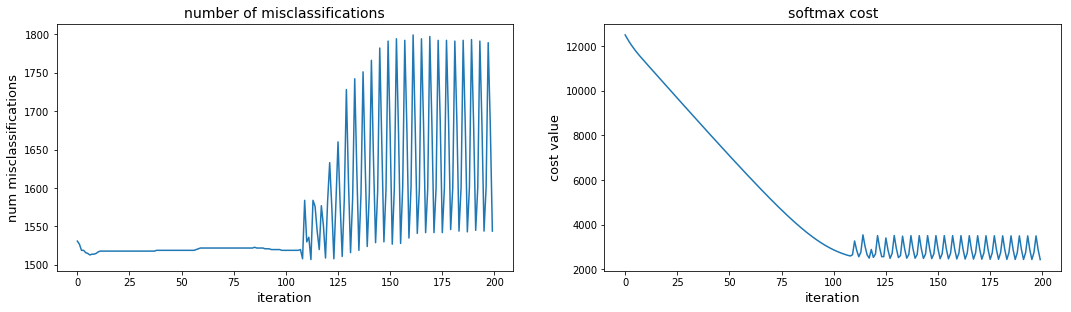

In [16]:
# create subplots
fig = plt.figure(figsize=(18,10))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.plot(np.arange(0, len(weight_hist)), count_evals[:len(weight_hist)])
ax1.set_xlabel('iteration', fontsize = 13)
ax1.set_ylabel('num misclassifications', rotation = 90, fontsize = 13)
ax1.set_title('number of misclassifications', fontsize = 14)

ax2.set_xlabel('iteration', fontsize = 13)
ax2.set_ylabel('cost value', rotation = 90, fontsize = 13)
ax2.set_title('softmax cost', fontsize = 14)
ax2.plot(np.arange(0, len(weight_hist)), cost_evals[:len(weight_hist)])

plt.show()

With **unnormalized** input, the gradient descent takes a long time to run and the cost starts from a really large value and can't converge within 200 iterations. The number of misclassification is also unacceptable.

## Try to use normalized input data

In [18]:
# normalize input
def normalize(data,data_mean,data_std):
    normalized_data = (data - data_mean)/data_std
    return normalized_data

In [19]:
x_means = np.mean(x, axis = 0)
x_stds = np.std(x, axis = 0)
x = normalize(x, x_means, x_stds)
x = np.asarray(x)
y = np.asarray(y)

In [26]:
w_init = np.random.randn(21, 1)
weight_hist = gradient_descent(func=softmax, alpha=10**-2, max_its=50, w=w_init)

In [27]:
count_evals = [] # list of misclassification number 
cost_evals = [] # list of softmax cost history 
for k in range(len(weight_hist)):
    w = weight_hist[k]
    count_evals.append(counting_cost(w)) # add each misclassification number history
    cost_evals.append(softmax(w)) # add each softmax cost history

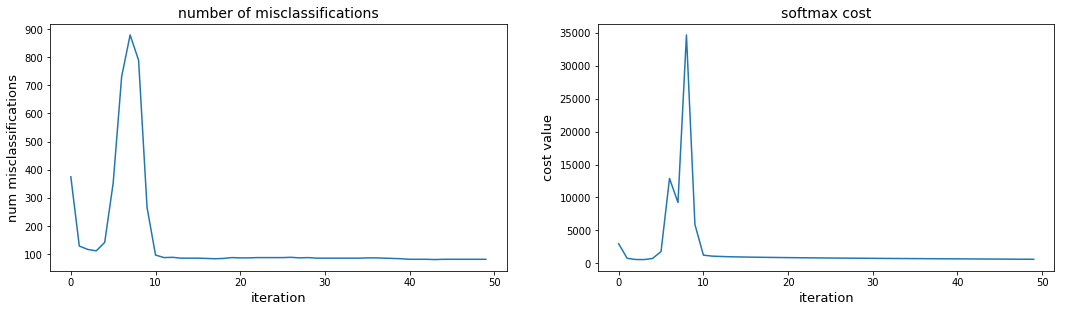

In [28]:
# create subplots
fig = plt.figure(figsize=(18,10))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.plot(np.arange(0, len(weight_hist)), count_evals[:len(weight_hist)])
ax1.set_xlabel('iteration', fontsize = 13)
ax1.set_ylabel('num misclassifications', rotation = 90, fontsize = 13)
ax1.set_title('number of misclassifications', fontsize = 14)

ax2.set_xlabel('iteration', fontsize = 13)
ax2.set_ylabel('cost value', rotation = 90, fontsize = 13)
ax2.set_title('softmax cost', fontsize = 14)
ax2.plot(np.arange(0, len(weight_hist)), cost_evals[:len(weight_hist)])

plt.show()

In [31]:
count_evals[-1]

array([ 82.])

In [32]:
N = np.shape(x)[0]
accuracy = str(1 - count_evals[-1]/N)
accuracy

'[ 0.97411616]'

With **normalized** input, we can use relatively large steplength. The initial cost significantly reduced. After only 50 interations, the costs converge and the number of missclassification is only 82 that achieved the accuracy rate of **97.4%**.